# ライブラリインストール

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy  
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.style.use("ggplot")
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') # warningが出ないように設定
pd.set_option("display.max_rows", None) # pandasの表示上限をなくす
pd.set_option("display.max_columns", None) # pandasの表示上限をなくす

# 概要
- 事後分布のサンプリング=MCMCで事後分布をサンプリングする
    - マルコフ連鎖を利用する
$$
マルコフ連鎖:新しいθ_tが直前のθ_{t-1}のみから決定する確率過程
$$

- 詳細釣り合い:詳細釣り合いを満たすと、確率分布が定常になる

# stanとは
- HMCを用いたMCMC用のプログラミング言語
## 特徴
- 統計モデルの記述が簡単
- HMCなので高速
- 様々な確率分布を用意している

## 計算の流れ
### 通常のベイズ統計
0. 下調べ：問題の背景を調べる
1. 下調べをもとに,モデルの作成
2. 得られたデータから事後分布の計算（MCMCで計算）

### pystanがやる内容
1. 下調べをもとに,モデルの作成(pystan上にモデリング)
    - データの性質を可視化して、尤度関数、事前分布が決まる　
    - データは正規分布に従いそう
2. 得られたデータから事後分布の計算（MCMCでサンプリング）

## pystanでの流れ
1. モデルの記述/コンパイル
2. データを辞書で定義
3. MCMCでサンプリング
4. 結果の抽出

# 例題(正規分布に従う80個のデータ)
- 観測の目的:与えられたデータからμ,σの分布を求める

## データの確認

In [2]:
data = np.random.randn(80)

In [3]:
df = pd.DataFrame(data )

In [4]:
df.head()

,0
0,-1.200452
1,-0.033873
2,0.904708
3,0.484256
4,0.802071


(array([ 3.,  6.,  8., 10., 16., 13., 10.,  8.,  3.,  3.]),
 array([-2.42056524, -1.9639019 , -1.50723856, -1.05057522, -0.59391188,
        -0.13724854,  0.3194148 ,  0.77607814,  1.23274148,  1.68940482,
         2.14606816]),
 <a list of 10 Patch objects>)

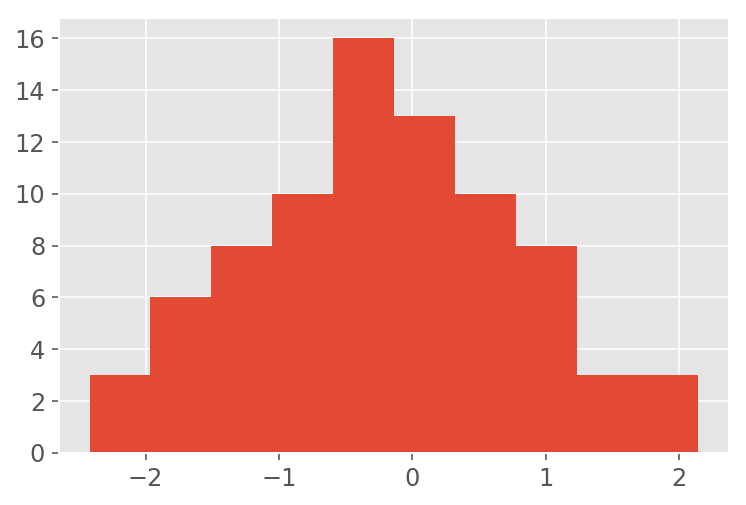

In [5]:
plt.hist(df[0])

## モデルの記述
### ポイント
1. ブロックごとに記述する
    - data/パラメータ/当駅モデル/事前分布のブロックを記述する
2. Stanの文法に従う(C++の文法)

In [6]:
stan_model = """ 
// 得ているデータ
data{
    //　データの個数
    int N;
    
    //実数系
    real Y[N];
}

//推定するパラメータ
parameters{
    real mu;
    real<lower=0> sigma;
 }
 
 //統計モデル
 model{ 
     //正規分布のモデル
     for (i in 1:N){
         //Yが正規分布に従うという記述
         Y[i] ~ normal(mu, sigma);
     }
     //事前分布
     mu ~ normal(0, 100);
    
}
""" 

## モデルのコンパイル

In [7]:
from pystan import StanModel
sm = StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6099df377ca5ebd3b16805e0d34cb5d1 NOW.


## データを辞書型で渡す

In [8]:
stan_data = {"N":df.shape[0], "Y":df[0]}
# df.shape[0] =>データのサイズ

## MCMCでサンプリング

In [9]:
fit = sm.sampling(data=stan_data, iter=2000, chains=3, warmup=500, seed=123)
# iter:反復回数回数
# shains:モンテカルロステップスを行う回数

## 結果の抽出

### fitの見方
- 上部:計算条件
- 下部；事後分布の平均値/事後分布の誤差収束
- Rhatが1以下出ないといけない

In [10]:
fit

Inference for Stan model: anon_model_6099df377ca5ebd3b16805e0d34cb5d1.
3 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     -0.21  1.6e-3   0.11  -0.44  -0.28  -0.21  -0.13   0.02   5002    1.0
sigma   1.02  1.3e-3   0.08   0.88   0.96   1.02   1.07    1.2   3785    1.0
lp__  -41.03    0.02   0.99 -43.74 -41.43 -40.73 -40.32 -40.05   2104    1.0

Samples were drawn using NUTS at Thu Jan 10 15:44:13 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

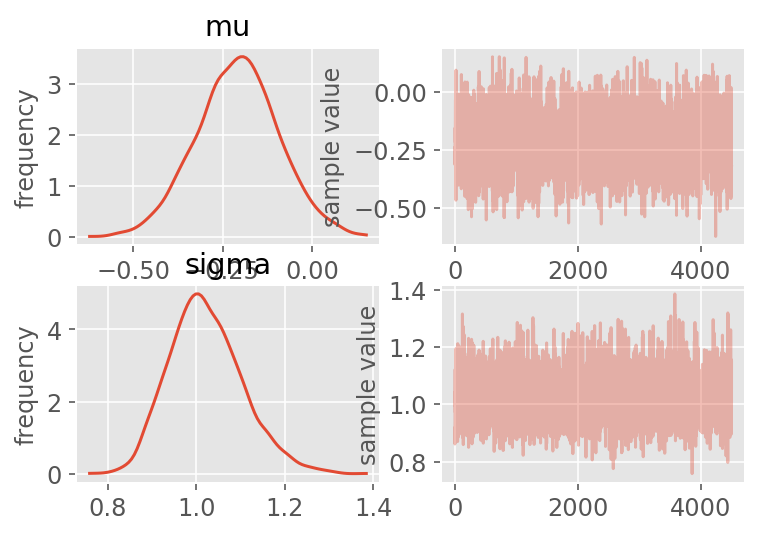

In [11]:
fig = fit.plot()
# 右側：トレースプロット：収束している